In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion

In [4]:
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

### Request HPC Resources

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='03:00:00',
    queue='scavenger',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35858 instead
  warnings.warn(


#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=177G
#SBATCH -t 03:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.96:35869 --name dummy-name --nthreads 36 --memory-limit 176.95GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/35858/status,
Dashboard: /proxy/35858/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.96:35869,Workers: 0
Dashboard: /proxy/35858/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [6]:
expt_datafiles = collect_tracer_files(model="CM4Xp125")
del expt_datafiles["spinup"]
expt_datafiles.keys()

dict_keys(['forced', 'control'])

In [7]:
def volume_weighted_average(ds):
    weights = (ds.thkcello * ds.areacello / ds.wet)
    weights = weights.where((ds.thkcello > 0) * (ds.wet > 0))
    weighted_ds = (ds.drop_vars(["thkcello"]) * weights).sum(["xh", "yh"], skipna = True) / weights.sum(["xh", "yh"], skipna = True)
    return weighted_ds

def zonal_volume_weighted_average(ds):
    weights = (ds.thkcello * ds.areacello / ds.wet)
    weights = weights.where((ds.thkcello > 0) * (ds.wet > 0))
    weighted_ds = (ds.drop_vars(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)
    return weighted_ds

In [9]:
latmin, latmax = -78, 60 #true max is 20 degrees max because the mediterranean is weird (nned to show henri)

ds_zon_ts_dict = {}
for key in expt_datafiles.keys():
    datafiles = expt_datafiles[key]
    ds_zons = []
    for (t, file) in enumerate(datafiles[20:25]): 
        if t % 5 == 0:
            print(key, ":", file)
        ds = read_tracer_and_zos_from_budget(file)
        
        ds["density"] = ds.sigma2_l * xr.where(ds.thkcello.fillna(0.0) > 0.0, 1, 0) 
        ds["density"] = ds["density"].where(ds["density"] > 0)
        ds["density"].attrs["cell_methods"] = ds["thetao"].attrs["cell_methods"]
        ds_remap = remap_sigma_to_depth(ds)

        lat_mask = (ds_remap.geolat > latmin) * (ds_remap.geolat < latmax)
        ds_remap_masked = ds_remap.where(lat_mask)
        ds_zon_avg = zonal_volume_weighted_average(ds_remap_masked).compute()

        ds_zons += [1 * ds_zon_avg]

    geolat_masked = ds_remap_masked.geolat.where(lat_mask)
    area_masked = ds_remap_masked.areacello.where(lat_mask)
    wet_masked = ds_remap_masked.wet.where(lat_mask)
    wet_masked = wet_masked.where(wet_masked > 0)

    ds_zon_ts = xr.concat(ds_zons, dim = "time").sortby("time")

    geolat_avg = (geolat_masked * area_masked / wet_masked).sum("xh") / (area_masked / wet_masked).sum("xh")
    geolat_avg = geolat_avg.compute()   # e.g. shape = (Ny,)
    
    ds_zon_ts = ds_zon_ts.assign_coords(geolat=("yh", geolat_avg.values))
    
    ds_zon_ts = ds_zon_ts.dropna(dim="yh", subset=["geolat"])
    ds_zon_ts_dict[key] = 1 * ds_zon_ts
    # savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"
    
    # savename = savedir + f"SO_Tracer_Zon_{key}_w_sigma2.nc"
    # print(f"Saving {key} to", ": ", savename)
    # ds_zon_ts.to_netcdf(savename)

ds_zon_ts_list = [
    ds_zon_ts_dict[dkey].expand_dims(exp=[dkey]) 
    for dkey in ds_zon_ts_dict.keys()
]
combined_zon_ts_ds = xr.concat(ds_zon_ts_list, dim="exp")
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"
savename = savedir + f"SO_Tracer_Zonal_Z.nc"
print(f"Saving to", ": ", savename)
# combined_zon_ts_ds.to_netcdf(savename)

forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1950-1954.zarr
no z_i provided
using a default setup
N = 41; H = 7000 meters; eta = 25 meters


/tmp/ipykernel_84299/2690238689.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)


no z_i provided
using a default setup
N = 41; H = 7000 meters; eta = 25 meters


/tmp/ipykernel_84299/2690238689.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)


no z_i provided
using a default setup
N = 41; H = 7000 meters; eta = 25 meters


/tmp/ipykernel_84299/2690238689.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)


no z_i provided
using a default setup
N = 41; H = 7000 meters; eta = 25 meters


/tmp/ipykernel_84299/2690238689.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)


no z_i provided
using a default setup
N = 41; H = 7000 meters; eta = 25 meters


/tmp/ipykernel_84299/2690238689.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)


control : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_piControl_tracers_sigma2_0201-0205.zarr
no z_i provided
using a default setup
N = 41; H = 7000 meters; eta = 25 meters


/tmp/ipykernel_84299/2690238689.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)


no z_i provided
using a default setup
N = 41; H = 7000 meters; eta = 25 meters


/tmp/ipykernel_84299/2690238689.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)


no z_i provided
using a default setup
N = 41; H = 7000 meters; eta = 25 meters


/tmp/ipykernel_84299/2690238689.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)


no z_i provided
using a default setup
N = 41; H = 7000 meters; eta = 25 meters


/tmp/ipykernel_84299/2690238689.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)


no z_i provided
using a default setup
N = 41; H = 7000 meters; eta = 25 meters


/tmp/ipykernel_84299/2690238689.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)


Saving control to :  /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/SO_Tracer_Zon_w_sigma2.nc


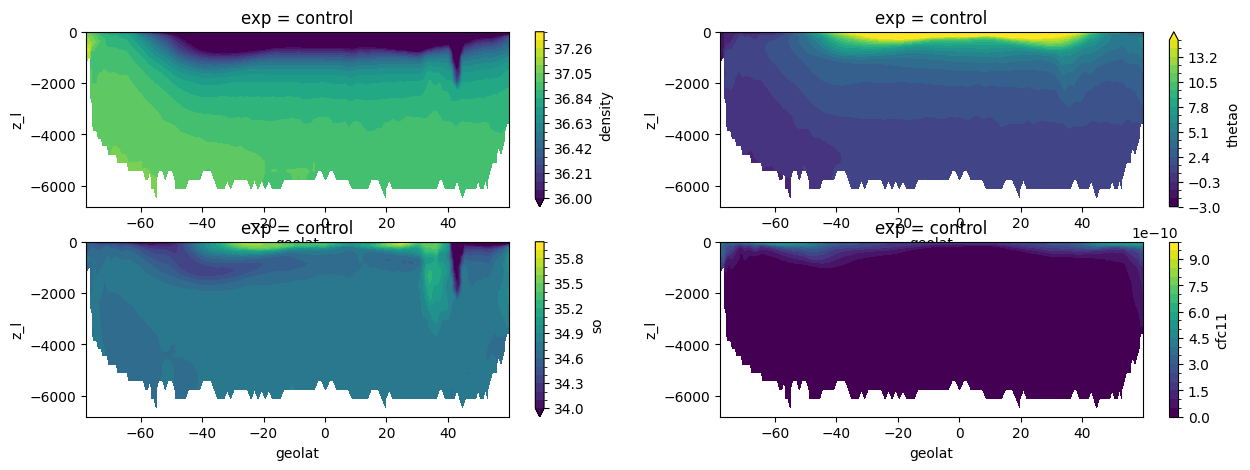

In [10]:
ds_zon_ts_tmp = combined_zon_ts_ds.sel(exp = "control")
fig, axes = plt.subplots(2, 2, figsize = (15, 5))
ax = axes.flatten()
ds_zon_ts_tmp.mean("time")["density"].T.plot.contourf(ax = ax[0],y = "z_l", x = "geolat", levels = 21, vmin = 36, vmax = 37.4)
ds_zon_ts_tmp.mean("time")["thetao"].T.plot.contourf(ax = ax[1],y = "z_l", x = "geolat", levels = 21, vmax = 15, vmin = -3)
ds_zon_ts_tmp.mean("time")["so"].T.plot.contourf(ax = ax[2],y = "z_l", x = "geolat", levels = 21, vmax = 36, vmin = 34)
ds_zon_ts_tmp.mean("time")["cfc11"].T.plot.contourf(ax = ax[3], y = "z_l", x = "geolat", levels = 21, vmax = 1e-9)

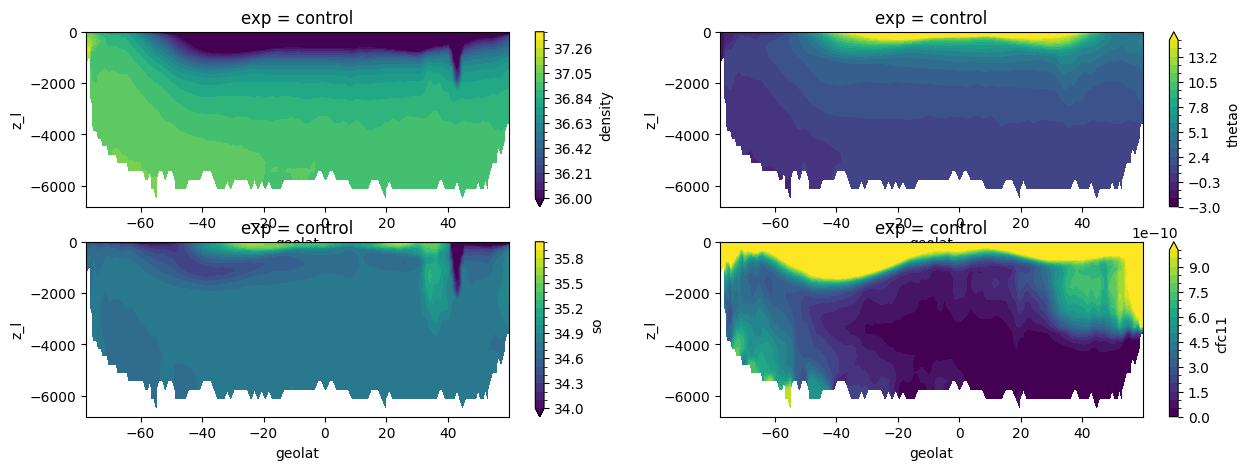

In [12]:
ds_zon_ts_tmp = combined_zon_ts_ds.sel(exp = "control")
fig, axes = plt.subplots(2, 2, figsize = (15, 5))
ax = axes.flatten()
ds_zon_ts_tmp.mean("time")["density"].T.plot.contourf(ax = ax[0],y = "z_l", x = "geolat", levels = 21, vmin = 36, vmax = 37.4)
ds_zon_ts_tmp.mean("time")["thetao"].T.plot.contourf(ax = ax[1],y = "z_l", x = "geolat", levels = 21, vmax = 15, vmin = -3)
ds_zon_ts_tmp.mean("time")["so"].T.plot.contourf(ax = ax[2],y = "z_l", x = "geolat", levels = 21, vmax = 36, vmin = 34)
ds_zon_ts_tmp.mean("time")["cfc11"].T.plot.contourf(ax = ax[3], y = "z_l", x = "geolat", levels = 21, vmax = 1e-9)

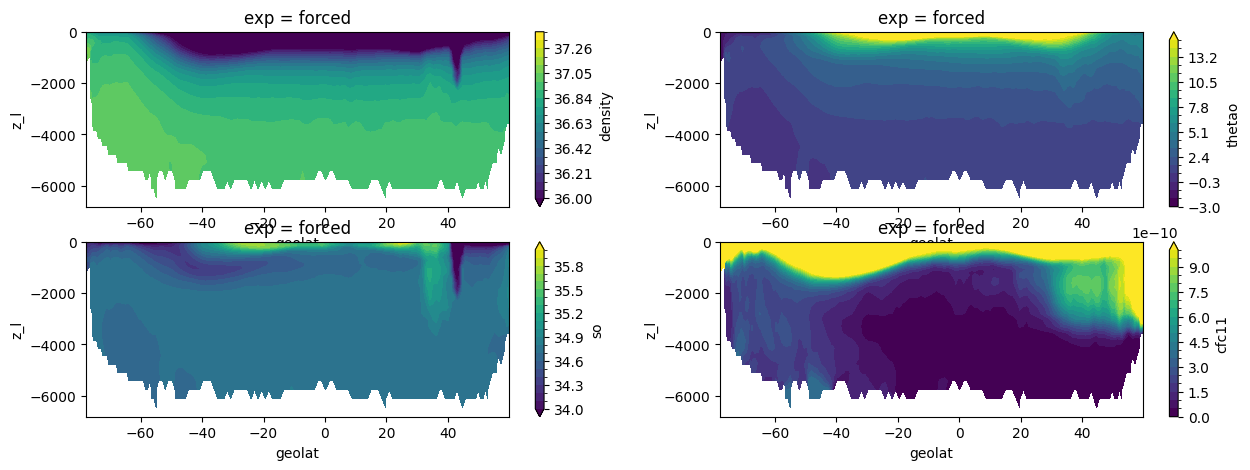

In [13]:
ds_zon_ts_tmp = combined_zon_ts_ds.sel(exp = "forced")
fig, axes = plt.subplots(2, 2, figsize = (15, 5))
ax = axes.flatten()
ds_zon_ts_tmp.mean("time")["density"].T.plot.contourf(ax = ax[0],y = "z_l", x = "geolat", levels = 21, vmin = 36, vmax = 37.4)
ds_zon_ts_tmp.mean("time")["thetao"].T.plot.contourf(ax = ax[1],y = "z_l", x = "geolat", levels = 21, vmax = 15, vmin = -3)
ds_zon_ts_tmp.mean("time")["so"].T.plot.contourf(ax = ax[2],y = "z_l", x = "geolat", levels = 21, vmax = 36, vmin = 34)
ds_zon_ts_tmp.mean("time")["cfc11"].T.plot.contourf(ax = ax[3], y = "z_l", x = "geolat", levels = 21, vmax = 1e-9)

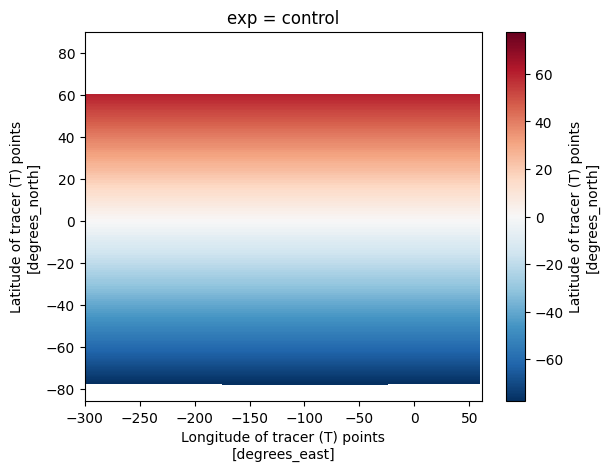

In [11]:
latmin, latmax = -78, 60
lat_mask = (ds_remap.geolat > latmin) * (ds_remap.geolat < latmax)
ds_remap.geolat.where(lat_mask).plot(x = "geolon", y = "geolat")